## Задача B2: антифрод через обнаружение аномалий (без учителя)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и подготовка данных

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv("/content/drive/MyDrive/study/group-HW-fraud/financial_loan.csv")

In [24]:
import re

# избавляюсь от current, добавляю target, чтобы в дальнейшем оценить модели
df = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
df["payment_ratio"] = df["total_payment"] / df["loan_amount"].replace(0, np.nan)
df["fraud_proxy"] = ((df["loan_status"] == "Charged Off") & (df["payment_ratio"] < 0.1)).astype(int)

# избавление от ликов / бесполезных / кореллирующих столбцов
cols_drop = ["total_payment", "payment_ratio", "last_payment_date", "next_payment_date", "last_credit_pull_date", "id", "member_id", "application_type", "grade"]
df = df.drop(columns=cols_drop, errors="ignore")

# получаем месяца выгрузок кредитов для OOT
df["issue_date"] = pd.to_datetime(df["issue_date"], dayfirst=True, errors="coerce")
dates_to_drop = pd.to_datetime(['2021-01-01', '2021-01-05', '2021-02-25', '2021-07-17', '2021-11-19', '2021-09-02', '2021-07-22', '2021-12-02', '2021-12-12', '2021-02-02'])
df = df[~df["issue_date"].isin(dates_to_drop)]
df["issue_month"] = df["issue_date"].dt.month.astype("int16")
df = df.drop(columns=["issue_date"], errors="ignore")

In [25]:
# преобразуем срок кредита в число
df["term_months"] = df["term"].astype(str).str.extract(r"(\d+)").astype("int16")
df = df.drop(columns=["term"], errors="ignore")

# sub_grade в числовой вид sub_grade_num
grade_map = {g: i+1 for i, g in enumerate(list("ABCDEFG"))}
df["sub_grade_num"] = df["sub_grade"].astype(str).apply(lambda s: 5*(grade_map.get(s[0], np.nan)-1) + int(s[1]) if len(s) >= 2 else np.nan)
df = df.drop(columns=["sub_grade"], errors="ignore")

# emp_title заполнение пропусков, обработка и получ новых признакрв
def clean_title(x):
    if pd.isna(x):
        return "unknown"
    x = str(x).lower()
    x = re.sub(r"[^a-z\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x if x else "unknown"
df["emp_title_clean"] = df["emp_title"].apply(clean_title)

# стаж работы в число
def parse_emp_length(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["n/a", "na", "none", "null", "unknown", ""]:
        return np.nan
    if "<" in s:
        return 0.5
    if "10" in s:
        return 10.0
    m = re.search(r"(\d+)", s)
    return float(m.group(1)) if m else np.nan
df["emp_length_years"] = df["emp_length"].apply(parse_emp_length)
df = df.drop(columns=["emp_length"], errors="ignore")


In [26]:
# fe из сашиного файла
annual_income_saved = df["annual_income"].copy()
p99_income = df["annual_income"].quantile(0.99)
df["log_income"] = np.log10(df["annual_income"].clip(upper=p99_income))
df = df.drop(columns=["annual_income"], errors="ignore")

# installment -> installment_rel_err fe из сашиного файла
def annuity_payment(L, annual_rate, n_months):
    r = annual_rate / 12.0
    if r == 0:
        return L / n_months
    return L * (r * (1 + r)**n_months) / ((1 + r)**n_months - 1)
df["installment_expected"] = df.apply(lambda row: annuity_payment(row["loan_amount"], row["int_rate"], row["term_months"]), axis=1)
df["installment_rel_err"] = (df["installment"] - df["installment_expected"]) / df["installment_expected"]
df = df.drop(columns=["installment_expected", "installment"], errors="ignore")

# loan_amount -> loan_to_income fe из сашиного файла
df["loan_to_income"] = df["loan_amount"] / annual_income_saved.replace(0, np.nan)
df = df.drop(columns=["loan_amount"], errors="ignore")

# emp_title получ новых признакрв
df["emp_title_is_unknown"] = (df["emp_title_clean"] == "unknown").astype(int)
df["emp_title_len"] = df["emp_title_clean"].str.len()
df = df.drop(columns=["emp_title"], errors="ignore")

In [27]:
df = df.drop(columns="int_rate", errors="ignore")

In [28]:
print(f"Размер после FE (до split): {df.shape}")

Размер после FE (до split): (37467, 18)


# OOT-разбиение по батчам (месяц issue_date)

In [29]:
train_months = [1, 2, 3, 4, 5, 6, 7, 8]
valid_months = [9, 10]
test_months = [11, 12]

train_df = df[df["issue_month"].isin(train_months)].copy()
valid_df = df[df["issue_month"].isin(valid_months)].copy()
test_df = df[df["issue_month"].isin(test_months)].copy()

print("\nРазмеры и доля fraud_proxy:")
for name, part in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(name, len(part), ", доля fraud_proxy:", part["fraud_proxy"].mean().round(4) if len(part) else None)


Размеры и доля fraud_proxy:
train 22469 , доля fraud_proxy: 0.0058
valid 7018 , доля fraud_proxy: 0.0058
test 7980 , доля fraud_proxy: 0.0043


# Подготовка признаков

In [30]:
# Списки признаков для ColumnTransformer
num_features = [
    "dti", "total_acc", "term_months", "log_income", "sub_grade_num", "installment_rel_err",
    "loan_to_income", "emp_title_is_unknown", "emp_title_len", "emp_length_years", "issue_month",
]
cat_features = ["verification_status", "home_ownership", "purpose", "address_state"]
text_feature = "emp_title_clean"

# Заполняем пропуски для текстового признака
for part in [train_df, valid_df, test_df]:
    part[text_feature] = part[text_feature].fillna("unknown").astype(str)

In [31]:
# Препроцессор для anomaly detection (числовые + OneHot для категориальных + TF-IDF для текста)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])
text_transformer = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=5)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
        ("txt", text_transformer, text_feature),
    ],
    remainder="drop",
    n_jobs=-1,
)

# Обучаем препроцессор на train
X_train_all = preprocessor.fit_transform(train_df)
X_valid_all = preprocessor.transform(valid_df)
X_test_all  = preprocessor.transform(test_df)

# Приводим к плотной матрице (OneClassSVM, LOF лучше работают с dense)
from scipy.sparse import issparse
if issparse(X_train_all):
    X_train_all = X_train_all.toarray()
    X_valid_all = X_valid_all.toarray()
    X_test_all = X_test_all.toarray()

print(f"Размерность признаков после препроцессинга: {X_train_all.shape[1]}")

Размерность признаков после препроцессинга: 1083


In [32]:
# from imblearn.over_sampling import RandomOverSampler

# y_train = train_df["fraud_proxy"].values.astype(int)

# ros = RandomOverSampler(sampling_strategy=0.03, random_state=42)
# X_train_ros, y_train_ros = ros.fit_resample(X_train_all, y_train)

# print("До:", X_train_all.shape, "fraud:", y_train.mean())
# print("После:", X_train_ros.shape, "fraud:", y_train_ros.mean())

# не помогло :(

# Обучение на нормальных профилях (fraud_proxy" = 0)
Даю моделям только нормальные профили, чтобы они выучили геометрию нормального пространства и далее могли выявлять аномалии.

Используемые модели:
1. Isolation Forest: случайно строит деревья и измеряет, насколько быстро объект “изолируется”.
2. One-Class SVMЕ: строит гладкую границу вокруг нормальных точек.
3. LOF (Local Outlier Factor): сравнивает плотность точки с плотностью соседей.

задача One-Class Classification

In [ ]:
normal_mask_train = (train_df["fraud_proxy"] == 0).values
X_train_normal = X_train_all[normal_mask_train]

n_normal = X_train_normal.shape[0]
print(f"Обучаем на {n_normal} нормальных профилях из {len(train_df)}")

sample_size = min(10000, n_normal)
X_train_normal_sample = X_train_normal[:sample_size] if n_normal > sample_size else X_train_normal



# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # ожидаем ~1% аномалий
    random_state=42,
    n_jobs=-1,
)

iso_forest.fit(X_train_normal)

# One-Class SVM
# Используем подвыборку для обучения
X_train_normal_sample = X_train_normal[:sample_size] if n_normal > sample_size else X_train_normal

one_class_svm = OneClassSVM(
    nu=0.01,  # доля аномалий
    kernel="rbf",
    gamma="scale",
)

one_class_svm.fit(X_train_normal_sample)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01,
    novelty=True,  # позволяет использовать predict на новых данных
)

lof.fit(X_train_normal)

Обучаем на 22338 нормальных профилях (Fully Paid) из 22469


LocalOutlierFactor(contamination=0.01, novelty=True)

# Предсказания и оценка качества
- прогоняю ВСЕ заявки через модели и получаю массив со score'ами от -1 до 1 (выше score => нормальнее заявка)
- сравниваю её с fraud_proxy
- считаю метрики


In [34]:
# Isolation Forest
iso_scores_train = iso_forest.decision_function(X_train_all)
iso_scores_valid = iso_forest.decision_function(X_valid_all)
iso_scores_test = iso_forest.decision_function(X_test_all)

# One-Class SVM
svm_scores_train = one_class_svm.decision_function(X_train_all)
svm_scores_valid = one_class_svm.decision_function(X_valid_all)
svm_scores_test = one_class_svm.decision_function(X_test_all)

# LOF
lof_scores_train = lof.decision_function(X_train_all)
lof_scores_valid = lof.decision_function(X_valid_all)
lof_scores_test = lof.decision_function(X_test_all)

# Преобразуем в anomaly scores (разворот шкалы для удобства)
iso_anomaly_scores_train = -iso_scores_train
iso_anomaly_scores_valid = -iso_scores_valid
iso_anomaly_scores_test = -iso_scores_test

svm_anomaly_scores_train = -svm_scores_train
svm_anomaly_scores_valid = -svm_scores_valid
svm_anomaly_scores_test = -svm_scores_test

lof_anomaly_scores_train = -lof_scores_train
lof_anomaly_scores_valid = -lof_scores_valid
lof_anomaly_scores_test = -lof_scores_test

# вытаскиваю таргет
y_train_proxy = train_df["fraud_proxy"].values
y_valid_proxy = valid_df["fraud_proxy"].values
y_test_proxy = test_df["fraud_proxy"].values

**функция подсчета метрик**:

In [35]:
def evaluate_anomaly_detection(name, anomaly_scores, y_proxy, threshold_pct=5):
    """
    Базовая оценка: precision, recall, PR-AUC.

    anomaly_scores: чем БОЛЬШЕ, тем более аномально (подозрительно)
    y_proxy: 1 для fraud_proxy, 0 иначе
    threshold_pct: топ-N% считаем аномалией (по умолчанию 5%)
    """
    y = np.asarray(y_proxy).astype(int)
    s = np.asarray(anomaly_scores, dtype=float)

    if y.sum() == 0:
        print(f"{name}: нет fraud_proxy для оценки")
        return None

    pr_auc = average_precision_score(y, s)

    n = len(y)
    k = max(1, int(n * threshold_pct / 100))
    threshold = np.percentile(s, 100 - threshold_pct)
    pred = (s >= threshold).astype(int)

    tp = (pred * y).sum()
    precision = tp / pred.sum() if pred.sum() > 0 else 0.0
    recall = tp / y.sum() if y.sum() > 0 else 0.0

    print(f"{name}: PR-AUC={pr_auc:.4f}, precision={precision:.4f}, recall={recall:.4f}")
    return {"pr_auc": pr_auc, "precision": precision, "recall": recall}

резы

In [36]:
print("\n=== Isolation Forest ===")
evaluate_anomaly_detection("IF train", iso_anomaly_scores_train, y_train_proxy)
evaluate_anomaly_detection("IF valid", iso_anomaly_scores_valid, y_valid_proxy)
evaluate_anomaly_detection("IF test",  iso_anomaly_scores_test,  y_test_proxy)

print("\n=== One-Class SVM ===")
evaluate_anomaly_detection("SVM train", svm_anomaly_scores_train, y_train_proxy)
evaluate_anomaly_detection("SVM valid", svm_anomaly_scores_valid, y_valid_proxy)
evaluate_anomaly_detection("SVM test",  svm_anomaly_scores_test,  y_test_proxy)

print("\n=== Local Outlier Factor ===")
evaluate_anomaly_detection("LOF train", lof_anomaly_scores_train, y_train_proxy)
evaluate_anomaly_detection("LOF valid", lof_anomaly_scores_valid, y_valid_proxy)
evaluate_anomaly_detection("LOF test",  lof_anomaly_scores_test,  y_test_proxy)


=== Isolation Forest ===
IF train: PR-AUC=0.0063, precision=0.0053, recall=0.0458
IF valid: PR-AUC=0.0051, precision=0.0028, recall=0.0244
IF test: PR-AUC=0.0076, precision=0.0125, recall=0.1471

=== One-Class SVM ===
SVM train: PR-AUC=0.0164, precision=0.0160, recall=0.1374
SVM valid: PR-AUC=0.0125, precision=0.0057, recall=0.0488
SVM test: PR-AUC=0.0057, precision=0.0075, recall=0.0882

=== Local Outlier Factor ===
LOF train: PR-AUC=0.0076, precision=0.0116, recall=0.0992
LOF valid: PR-AUC=0.0056, precision=0.0057, recall=0.0488
LOF test: PR-AUC=0.0040, precision=0.0025, recall=0.0294


{'pr_auc': np.float64(0.003964762455984842),
 'precision': np.float64(0.002506265664160401),
 'recall': np.float64(0.029411764705882353)}

# Анализ распределения anomaly scores по loan_status

Если модель полезна, хочется видеть тенденцию:
- Fully Paid => более “нормальные” (меньше anomaly score)
- Charged Off => более “аномальные” (больше anomaly score)

То есть гистограмма Charged Off должна быть сдвинута вправо (к большим score), а Fully Paid — левее.

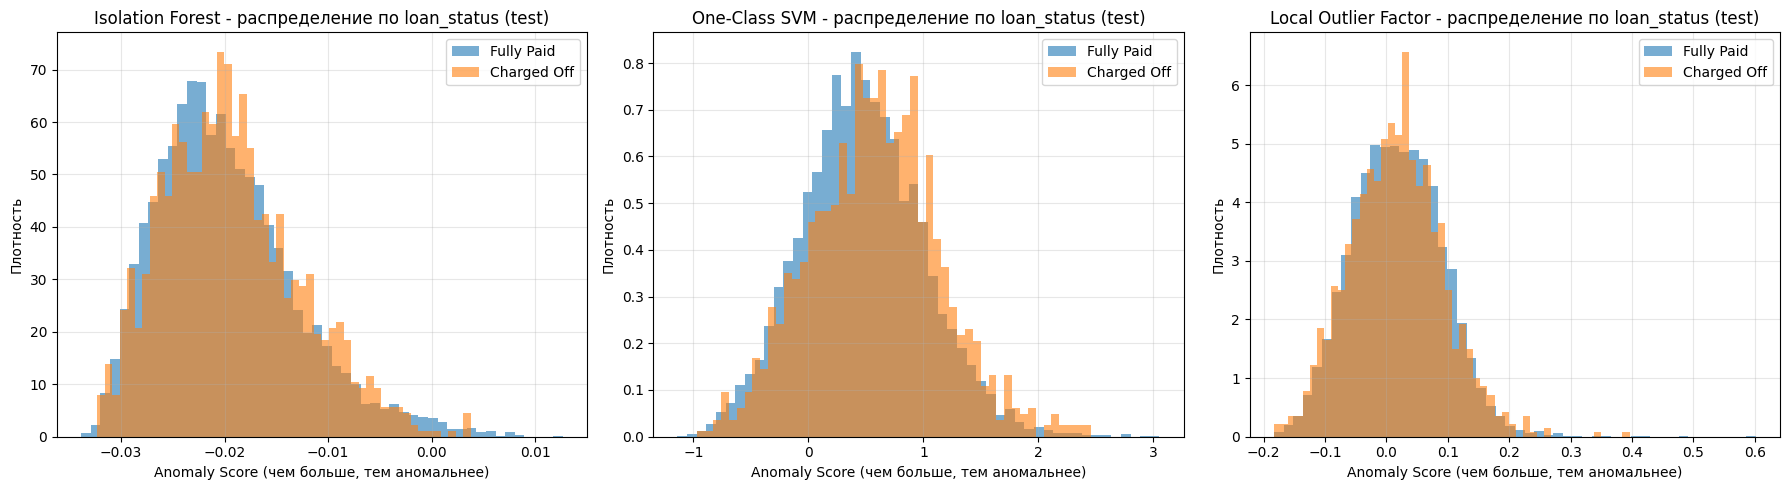


Средние anomaly scores по loan_status (test):

Isolation Forest:
  Fully Paid: -0.0198
  Charged Off: -0.0194

One-Class SVM:
  Fully Paid: 0.4696
  Charged Off: 0.5823

Local Outlier Factor:
  Fully Paid: 0.0182
  Charged Off: 0.0167


In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ("Isolation Forest", iso_anomaly_scores_test),
    ("One-Class SVM", svm_anomaly_scores_test),
    ("Local Outlier Factor", lof_anomaly_scores_test),
]

for idx, (method_name, scores) in enumerate(methods):
    ax = axes[idx]

    for status in ["Fully Paid", "Charged Off"]:
        mask = test_df["loan_status"] == status
        if mask.sum() > 0:
            ax.hist(
                scores[mask],
                bins=50,
                alpha=0.6,
                label=status,
                density=True,
            )

    ax.set_xlabel("Anomaly Score (чем больше, тем аномальнее)")
    ax.set_ylabel("Плотность")
    ax.set_title(f"{method_name} - распределение по loan_status (test)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСредние anomaly scores по loan_status (test):")
for method_name, scores in methods:
    print(f"\n{method_name}:")
    for status in ["Fully Paid", "Charged Off"]:
        mask = test_df["loan_status"] == status
        if mask.sum() > 0:
            mean_score = scores[mask].mean()
            print(f"  {status}: {mean_score:.4f}")

# Флагирование наиболее аномальных заявок

- берём anomaly score, который модель без учителя присвоила каждой заявке
- отбираем верхние 5% самых “странных” (то есть тех, которые сильнее всего отличаются от нормальных Fully Paid профилей),
- объявляем их очередью на ручную проверку
- сравниваем эту очередь с proxy-таргетом (fraud_proxy), чтобы понять, концентрируется ли подозрительное поведение в верхнем хвосте скоринга
- считаем:
  - сколько proxy-fraud попало в очередь (precision),
  - какую долю всех proxy-fraud мы поймали (recall)
  - во сколько раз эта очередь лучше случайного отбора (uplift)

In [46]:
# сравнение IF vs SVM при разных значениях threshold
def flag_anomalies(anomaly_scores, threshold_percentile):
    """Флагирует топ-N% наиболее аномальных заявок"""
    threshold = np.percentile(anomaly_scores, threshold_percentile)
    flags = (anomaly_scores >= threshold).astype(int)
    return flags

for pct in [95, 90, 80, 70, 60, 50]:
    print(f"\n=== threshold_percentile = {pct} (топ {100-pct}%) ===")
    for name, scores in [("Isolation Forest", iso_anomaly_scores_test), ("One-Class SVM", svm_anomaly_scores_test)]:
        flags = flag_anomalies(scores, threshold_percentile=pct)
        cm = confusion_matrix(test_df["fraud_proxy"], flags)
        tp, fp, fn = cm[1,1], cm[0,1], cm[1,0]
        prec = tp/(tp+fp) if (tp+fp)>0 else 0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0
        uplift = (tp/(tp+fp)) / test_df["fraud_proxy"].mean() if (tp+fp)>0 and test_df["fraud_proxy"].mean()>0 else 0
        print(f"  {name}: Precision={prec:.4f}, Recall={rec:.4f}, Uplift={uplift:.2f}x")


=== threshold_percentile = 95 (топ 5%) ===
  Isolation Forest: Precision=0.0125, Recall=0.1471, Uplift=2.94x
  One-Class SVM: Precision=0.0075, Recall=0.0882, Uplift=1.76x

=== threshold_percentile = 90 (топ 10%) ===
  Isolation Forest: Precision=0.0088, Recall=0.2059, Uplift=2.06x
  One-Class SVM: Precision=0.0050, Recall=0.1176, Uplift=1.18x

=== threshold_percentile = 80 (топ 20%) ===
  Isolation Forest: Precision=0.0069, Recall=0.3235, Uplift=1.62x
  One-Class SVM: Precision=0.0056, Recall=0.2647, Uplift=1.32x

=== threshold_percentile = 70 (топ 30%) ===
  Isolation Forest: Precision=0.0054, Recall=0.3824, Uplift=1.27x
  One-Class SVM: Precision=0.0058, Recall=0.4118, Uplift=1.37x

=== threshold_percentile = 60 (топ 40%) ===
  Isolation Forest: Precision=0.0056, Recall=0.5294, Uplift=1.32x
  One-Class SVM: Precision=0.0060, Recall=0.5588, Uplift=1.40x

=== threshold_percentile = 50 (топ 50%) ===
  Isolation Forest: Precision=0.0050, Recall=0.5882, Uplift=1.18x
  One-Class SVM: Pre

In [48]:
# One-Class SVM как лучшая
def flag_anomalies(anomaly_scores, threshold_percentile=60):
    """Флагирует топ-N% наиболее аномальных заявок"""
    threshold = np.percentile(anomaly_scores, threshold_percentile)
    flags = (anomaly_scores >= threshold).astype(int)
    return flags, threshold

svm_flags_test, svm_threshold = flag_anomalies(svm_anomaly_scores_test, threshold_percentile=60)

test_df["svm_anomaly_flag"] = svm_flags_test
test_df["svm_anomaly_score"] = svm_anomaly_scores_test

print(f"One-Class SVM | Порог аномальности (60-й перцентиль): {svm_threshold:.4f}")
print(f"\nФлагировано как аномалии: {svm_flags_test.sum()} из {len(test_df)} ({svm_flags_test.mean()*100:.2f}%)")

pr_auc_svm = average_precision_score(test_df["fraud_proxy"], svm_anomaly_scores_test)
print(f"PR-AUC: {pr_auc_svm:.4f}")

print("\n=== Анализ флагированных заявок (SVM) ===")
print("\nРаспределение по loan_status:")
print(test_df[test_df["svm_anomaly_flag"] == 1]["loan_status"].value_counts())
print("\nРаспределение по fraud_proxy:")
print(test_df[test_df["svm_anomaly_flag"] == 1]["fraud_proxy"].value_counts())

print("\nДоля fraud_proxy среди флагированных:")
fraud_rate_flagged_svm = test_df[test_df["svm_anomaly_flag"] == 1]["fraud_proxy"].mean()
fraud_rate_overall = test_df["fraud_proxy"].mean()
print(f"  Флагированные: {fraud_rate_flagged_svm:.4f}")
print(f"  Общая: {fraud_rate_overall:.4f}")
print(f"  Улучшение: {fraud_rate_flagged_svm / fraud_rate_overall:.2f}x")

print("\n=== Confusion Matrix (svm_anomaly_flag vs fraud_proxy) ===")
cm_svm = confusion_matrix(test_df["fraud_proxy"], test_df["svm_anomaly_flag"])
print(cm_svm)
print("\nPrecision (среди флагированных, сколько действительно fraud_proxy):")
precision_svm = cm_svm[1, 1] / (cm_svm[1, 1] + cm_svm[0, 1]) if (cm_svm[1, 1] + cm_svm[0, 1]) > 0 else 0
print(f"  {precision_svm:.4f}")
print("\nRecall (сколько fraud_proxy мы поймали):")
recall_svm = cm_svm[1, 1] / (cm_svm[1, 1] + cm_svm[1, 0]) if (cm_svm[1, 1] + cm_svm[1, 0]) > 0 else 0
print(f"  {recall_svm:.4f}")

One-Class SVM | Порог аномальности (60-й перцентиль): 0.6023

Флагировано как аномалии: 3192 из 7980 (40.00%)
PR-AUC: 0.0057

=== Анализ флагированных заявок (SVM) ===

Распределение по loan_status:
loan_status
Fully Paid     2606
Charged Off     586
Name: count, dtype: int64

Распределение по fraud_proxy:
fraud_proxy
0    3173
1      19
Name: count, dtype: int64

Доля fraud_proxy среди флагированных:
  Флагированные: 0.0060
  Общая: 0.0043
  Улучшение: 1.40x

=== Confusion Matrix (svm_anomaly_flag vs fraud_proxy) ===
[[4773 3173]
 [  15   19]]

Precision (среди флагированных, сколько действительно fraud_proxy):
  0.0060

Recall (сколько fraud_proxy мы поймали):
  0.5588
